# Simulated attenuation through a cube
We walk through Beer-Lambert attenuation step by step: cast rays through a synthetic cube, generate transmitted intensities, invert them to recover path lengths, and rebuild a 3D occupancy volume.


## Step 1 - Imports and plotting defaults
We begin by pulling in NumPy and Matplotlib, and set a few plotting preferences to keep figures consistent.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Configure Matplotlib for consistent colour maps and figure sizes.
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["image.cmap"] = "viridis"

# Keep NumPy printing tidy when we inspect arrays.
np.set_printoptions(precision=3, suppress=True)


## Step 2 - Geometry and ray helpers
We describe an axis-aligned cube, compute intersections between rays and the cube, and add a few utility functions around Beer-Lambert attenuation.


In [8]:
from dataclasses import dataclass

@dataclass
class Cube:
    center: np.ndarray
    edge: float

    def __post_init__(self):
        self.center = np.asarray(self.center, dtype=np.float32)
        self.edge = float(self.edge)
        half = self.edge / 2.0
        self.min_corner = self.center - half
        self.max_corner = self.center + half

    def chord_lengths(self, origins: np.ndarray, directions: np.ndarray) -> np.ndarray:
        """Distance travelled inside the cube for each ray."""
        directions_norm = directions / np.linalg.norm(directions, axis=-1, keepdims=True)
        lengths = np.zeros(origins.shape[:-1], dtype=np.float32)

        t_min = np.full(lengths.shape, -np.inf, dtype=np.float32)
        t_max = np.full(lengths.shape, np.inf, dtype=np.float32)
        valid = np.ones(lengths.shape, dtype=bool)

        for axis in range(3):
            dir_comp = directions_norm[..., axis]
            orig_comp = origins[..., axis]
            min_c = self.min_corner[axis]
            max_c = self.max_corner[axis]
            parallel = np.isclose(dir_comp, 0.0)
            outside = (orig_comp < min_c) | (orig_comp > max_c)
            valid &= ~(parallel & outside)
            inv_dir = np.divide(1.0, dir_comp, out=np.zeros_like(dir_comp), where=~parallel)
            t1 = (min_c - orig_comp) * inv_dir
            t2 = (max_c - orig_comp) * inv_dir
            axis_t_min = np.minimum(t1, t2)
            axis_t_max = np.maximum(t1, t2)
            t_min = np.maximum(t_min, axis_t_min)
            t_max = np.minimum(t_max, axis_t_max)

        valid &= (t_max > t_min) & (t_max > 0.0)
        lengths[valid] = (t_max - t_min)[valid]
        lengths[~valid] = 0.0
        return lengths

def generate_parallel_rays(grid_size: int, lateral_extent: float, source_z: float):
    """Create a grid of parallel rays aligned with +z."""
    axis = np.linspace(-lateral_extent / 2.0, lateral_extent / 2.0, grid_size, dtype=np.float32)
    xv, yv = np.meshgrid(axis, axis, indexing="xy")
    origins = np.stack([xv, yv, np.full_like(xv, source_z)], axis=-1)
    directions = np.zeros_like(origins)
    directions[..., 2] = 1.0  # parallel rays travelling along +z
    return origins.astype(np.float32), directions.astype(np.float32), axis

def simulate_measurements(lengths: np.ndarray, mu: float, I_s: float = 1.0, noise_std: float = 0.0, rng: np.random.Generator | None = None):
    """Apply Beer-Lambert attenuation with optional additive Gaussian noise."""
    if rng is None:
        rng = np.random.default_rng()
    I_s_array = np.full_like(lengths, fill_value=I_s, dtype=np.float32)
    I_f = I_s_array * np.exp(-mu * lengths)
    if noise_std > 0.0:
        I_f = I_f + rng.normal(0.0, noise_std, size=I_f.shape)
    I_f = np.clip(I_f, 1e-8, None)
    return I_f.astype(np.float32), I_s_array

def recover_lengths(I_f: np.ndarray, I_s: np.ndarray, mu: float) -> np.ndarray:
    """Invert the attenuation model to estimate path lengths."""
    ratio = np.clip(I_f / I_s, 1e-8, 1.0)
    return (-np.log(ratio) / mu).astype(np.float32)

def carve_volume(length_map: np.ndarray, axis: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Reconstruct occupancy along z assuming the cube is centered at the origin."""
    z_axis = axis
    half_lengths = 0.5 * length_map[..., None]
    occupancy = (np.abs(z_axis)[None, None, :] <= half_lengths).astype(np.float32)
    return occupancy, z_axis

def ground_truth_volume(cube: Cube, axis: np.ndarray) -> np.ndarray:
    """Reference voxel grid of the cube for evaluation."""
    X, Y, Z = np.meshgrid(axis, axis, axis, indexing="ij")
    half = cube.edge / 2.0
    mask = (
        (np.abs(X - cube.center[0]) <= half)
        & (np.abs(Y - cube.center[1]) <= half)
        & (np.abs(Z - cube.center[2]) <= half)
    )
    return mask.astype(np.float32)

def summarize_volume_error(reconstructed: np.ndarray, ground_truth: np.ndarray) -> dict[str, float]:
    """Basic overlap and distance metrics."""
    recon_mask = reconstructed > 0.5
    truth_mask = ground_truth > 0.5
    intersection = np.count_nonzero(recon_mask & truth_mask)
    union = np.count_nonzero(recon_mask | truth_mask)
    iou = intersection / union if union else 1.0
    l1 = float(np.mean(np.abs(reconstructed - ground_truth)))
    return {"iou": float(iou), "l1": l1}


## Step 3 - Cast rays and simulate measurements
We now place a detector grid, trace rays through the cube, and compute the attenuated intensities while adding a touch of noise to resemble measurements.


In [9]:
# Simulation configuration.
grid_size = 128           # detector resolution in x and y
lateral_extent = 1.2      # physical size covered by the detector
source_z = -0.8           # rays start below the cube and head towards +z
mu = 0.8                  # known linear attenuation coefficient
noise_std = 0.01          # standard deviation of measurement noise

# Construct cube geometry and rays.
cube = Cube(center=np.array([0.0, 0.0, 0.0]), edge=0.6)
origins, directions, axis = generate_parallel_rays(grid_size, lateral_extent, source_z)

# Analytical path lengths and synthetic measurements.
true_lengths = cube.chord_lengths(origins, directions)
rng = np.random.default_rng(seed=12)
I_f, I_s = simulate_measurements(true_lengths, mu, I_s=1.0, noise_std=noise_std, rng=rng)


## Step 4 - Visualise path lengths and measured intensities
The left panel shows the true distance travelled inside the cube for each ray, while the right panel displays the corresponding attenuated intensities.


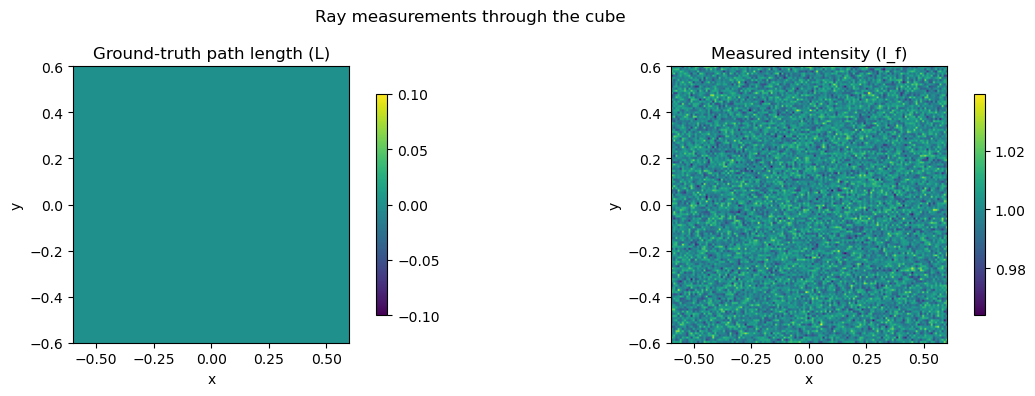

In [10]:
extent = [axis[0], axis[-1], axis[0], axis[-1]]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im0 = ax[0].imshow(true_lengths, extent=extent, origin="lower")
ax[0].set_title("Ground-truth path length (L)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(im0, ax=ax[0], shrink=0.8)

im1 = ax[1].imshow(I_f, extent=extent, origin="lower")
ax[1].set_title("Measured intensity (I_f)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(im1, ax=ax[1], shrink=0.8)

fig.suptitle("Ray measurements through the cube")
plt.tight_layout()


## Step 5 - Reconstruct the cube
We invert Beer-Lambert to recover the chord lengths, carve a volume assuming symmetry around the detector plane, and compare the resulting voxel grid to the analytical cube.


In [11]:
recovered_lengths = recover_lengths(I_f, I_s, mu)
length_error = float(np.mean(np.abs(recovered_lengths - true_lengths)))

reconstructed_volume, z_axis = carve_volume(recovered_lengths, axis)
ground_truth = ground_truth_volume(cube, axis)
metrics = summarize_volume_error(reconstructed_volume, ground_truth)

print(f"Mean absolute error on length map: {length_error:.4f} units")
print(f"Reconstructed volume IoU: {metrics['iou']:.4f}")
print(f"Reconstructed vs. truth L1 distance: {metrics['l1']:.4f}")


Mean absolute error on length map: 0.0050 units
Reconstructed volume IoU: 0.0070
Reconstructed vs. truth L1 distance: 0.1269


## Step 6 - Inspect reconstructed slices
Finally, we compare central slices of the ground truth and the reconstructed volume in both the xy and xz planes.


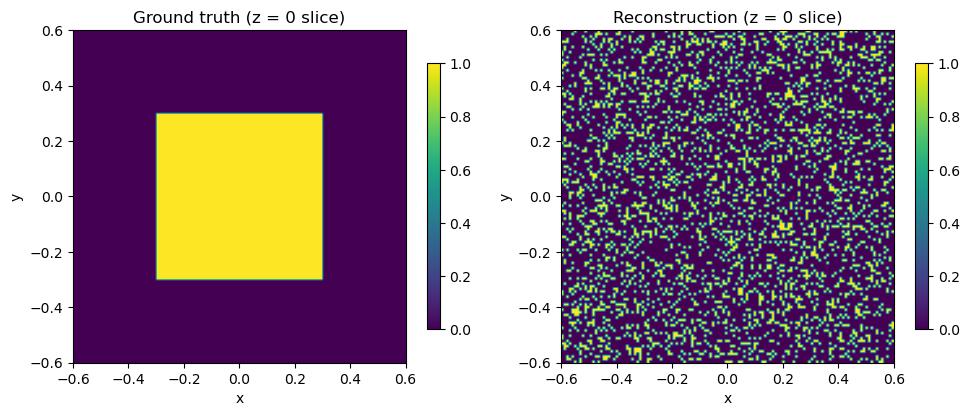

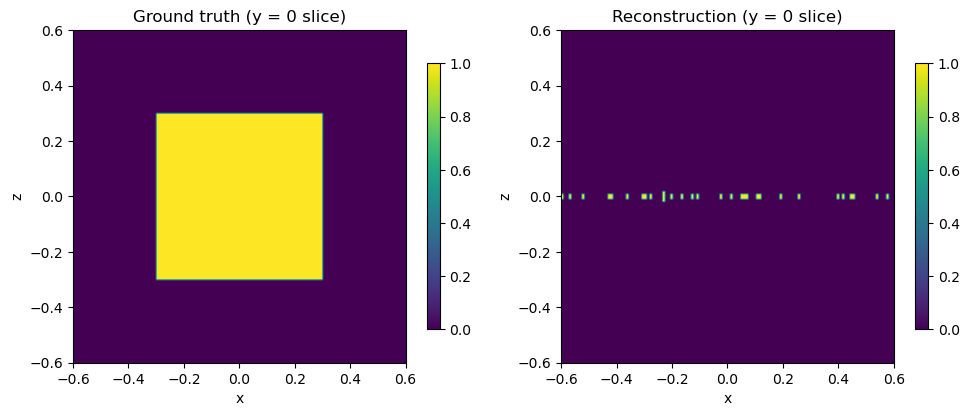

In [12]:
mid_z = reconstructed_volume.shape[2] // 2
mid_y = reconstructed_volume.shape[1] // 2

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im_xy_truth = ax[0].imshow(ground_truth[:, :, mid_z], extent=extent, origin="lower")
ax[0].set_title("Ground truth (z = 0 slice)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(im_xy_truth, ax=ax[0], shrink=0.8)

im_xy_recon = ax[1].imshow(reconstructed_volume[:, :, mid_z], extent=extent, origin="lower")
ax[1].set_title("Reconstruction (z = 0 slice)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(im_xy_recon, ax=ax[1], shrink=0.8)
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
xz_extent = [axis[0], axis[-1], z_axis[0], z_axis[-1]]
truth_xz = np.swapaxes(ground_truth[:, mid_y, :], 0, 1)
recon_xz = np.swapaxes(reconstructed_volume[:, mid_y, :], 0, 1)
im_xz_truth = ax[0].imshow(truth_xz, extent=xz_extent, origin="lower")
ax[0].set_title("Ground truth (y = 0 slice)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("z")
fig.colorbar(im_xz_truth, ax=ax[0], shrink=0.8)

im_xz_recon = ax[1].imshow(recon_xz, extent=xz_extent, origin="lower")
ax[1].set_title("Reconstruction (y = 0 slice)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")
fig.colorbar(im_xz_recon, ax=ax[1], shrink=0.8)
plt.tight_layout()
